In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from pandas import Series, DataFrame
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
#Read dataset and mount dataset in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Read dataset with port restriction
#df = pd.read_csv('/content/gdrive/MyDrive/Nasim/CICIDS_DATASETS/CICIDS2017_sample.csv') ### Haghighat
df = pd.read_csv('/content/gdrive/MyDrive/Colab_project/me_cicids.csv') ### Original ###
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.500000,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.500000,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.000000,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.000000,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.000000,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964882,53,205,2,2,74,202,37,37,37.000000,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
1964883,53,165,2,2,104,224,52,52,52.000000,0.000000,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
1964884,445,247267,16,12,1648,1908,252,0,103.000000,88.296470,...,20,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
1964885,53,261,2,2,64,96,32,32,32.000000,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [72]:
df.Label.value_counts()

BENIGN          1627748
DoS              321769
Brute-Force        9152
PortScan           2791
Web Attack         2143
Bot                1248
Infiltration         36
Name: Label, dtype: int64

Preprocessing (normalization by Min-Max)

In [ ]:
# MIN-MAX normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

split train set and test set

In [ ]:
def label_decoder(labels, encoder):
  return encoder.inverse_transform(labels)

In [ ]:
labelencoder = LabelEncoder()
# df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
y_true_enc = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = y_true_enc.reshape(-1,1)
y = np.ravel(y)

## Backward Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import feature_importances

estimator = RandomForestClassifier(n_estimators=10)
selector = RFE(estimator, n_features_to_select=20, step=1)
selector.fit(X, y)
X_selected = selector.transform(X)
pd.DataFrame(X_selected).to_csv('/content/gdrive/MyDrive/ISO-IDS/RFE_features.csv')

In [ ]:
def LDA(data, labels, n = 6):
  print(">>> Linear Discriminant Analysis:")
  clf = LinearDiscriminantAnalysis(n_components=n)
  clf.fit(data, labels)
  features = clf.transform(data)
  print(f"\t# of components: {n}\n\t# of Seen Features: {clf.n_features_in_}\n\tOriginal: {data.shape}\n\tReduced:  {features.shape}\n\tClasses:  {clf.classes_}\n\tVariation: {clf.explained_variance_ratio_} = {np.sum(clf.explained_variance_ratio_)}")
  return features

X_lda = LDA(X_selected,y)
pd.DataFrame(X_lda).to_csv('/content/gdrive/MyDrive/ISO-IDS/lda_features.csv')

>>> Linear Discriminant Analysis:
	# of components: 6
	# of Seen Features: 20
	Original: (1964887, 20)
	Reduced:  (1964887, 6)
	Classes:  [0 1 2 3 4 5 6]
	Variation: [9.64331667e-01 1.73145976e-02 9.98306886e-03 4.28510456e-03
 3.42520402e-03 6.60357964e-04] = 0.9999999999999998


In [ ]:
X.shape

(1964887, 78)

In [ ]:
X_selected.shape

(1964887, 20)

In [ ]:
X_lda.shape

(1964887, 6)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X_lda,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
 X_train.shape
 pd.Series(y_train).value_counts()

0    1302198
3     257415
2       7322
5       2233
6       1714
1        998
4         29
dtype: int64

Oversampling by SMOTE

In [82]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:2000, 4:2000}) # Create 2000 samples for the minority class "4"

X_train, y_train = smote.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

0    1302198
3     257415
2       7322
5       2233
1       2000
4       2000
6       1714
dtype: int64

Training two base learners: Random Forest and KNN

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict_rf=rf.predict(X_test)
pd.DataFrame(y_predict_rf).to_csv('/content/gdrive/MyDrive/ISO-IDS/y_predict_rf.csv')

#  k-Nearest Neighbors (kNN) training and prediction
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
y_predict_knn = classifier.predict(X_test)
kn=classifier.score(X_test,y_test)
pd.DataFrame(y_predict_knn).to_csv('/content/gdrive/MyDrive/ISO-IDS/y_predict_knn.csv')

In [ ]:
y_true = y_test
y_true_dec = label_decoder(y_true, labelencoder)

Accuracy of RF: 0.9989770419718152
Precision of RF: 0.9989899385217231
Recall of RF: 0.9989770419718152
F1-score of RF: 0.9989822006521027
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325550
           1       0.69      0.74      0.71       250
           2       1.00      0.99      0.99      1830
           3       1.00      1.00      1.00     64354
           4       0.38      0.43      0.40         7
           5       0.97      0.93      0.95       558
           6       0.98      0.97      0.98       429

    accuracy                           1.00    392978
   macro avg       0.86      0.86      0.86    392978
weighted avg       1.00      1.00      1.00    392978



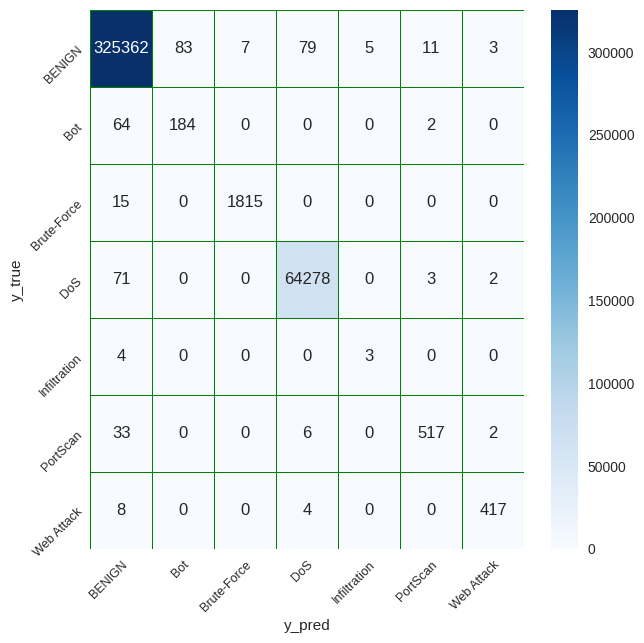

In [71]:
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict_rf, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict_rf))

y_pred_dec = labelencoder.inverse_transform(y_predict_rf)

cm = confusion_matrix(y_true_dec, y_pred_dec)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax, cmap="Blues")

plt.xlabel("y_pred")
plt.ylabel("y_true")

ax.tick_params(axis='both', which='major', labelsize=9)
ax.xaxis.set_ticklabels(np.unique(y_true_dec));
ax.yaxis.set_ticklabels(np.unique(y_pred_dec));

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

**KNN**

Accuracy of KNN: 0.9985851625281822
Precision of KNN: 0.9986575768604493
Recall of KNN: 0.9985851625281822
F1-score of KNN: 0.9986143259097516
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325550
           1       0.65      0.78      0.71       250
           2       0.99      0.99      0.99      1830
           3       1.00      1.00      1.00     64354
           4       0.17      0.57      0.26         7
           5       0.90      0.85      0.87       558
           6       0.97      0.98      0.97       429

    accuracy                           1.00    392978
   macro avg       0.81      0.88      0.83    392978
weighted avg       1.00      1.00      1.00    392978



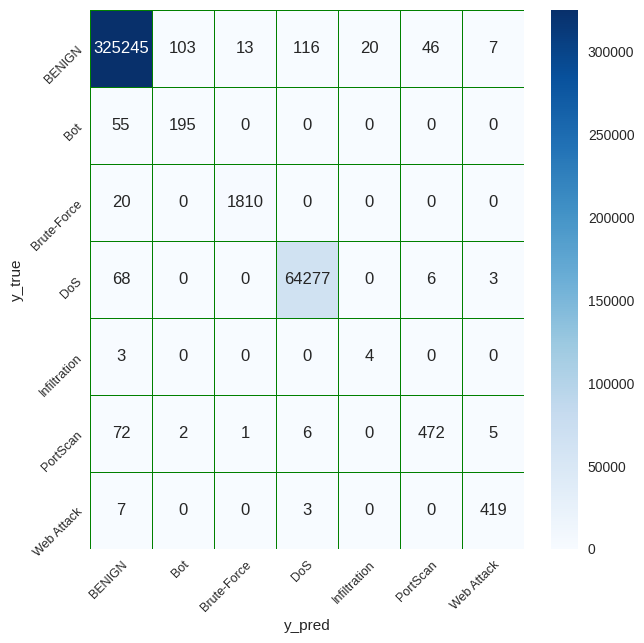

In [68]:
print('Accuracy of KNN: '+ str(kn))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict_knn, average='weighted')
print('Precision of KNN: '+(str(precision)))
print('Recall of KNN: '+(str(recall)))
print('F1-score of KNN: '+(str(fscore)))

print(classification_report(y_true,y_predict_knn))

y_pred_dec = label_decoder(y_predict_knn, labelencoder)
cm=confusion_matrix(y_true_dec,y_pred_dec)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax, cmap="Blues")

plt.xlabel("y_pred")
plt.ylabel("y_true")

ax.tick_params(axis='both', which='major', labelsize=9)
ax.xaxis.set_ticklabels(np.unique(y_true_dec));
ax.yaxis.set_ticklabels(np.unique(y_pred_dec));

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [ ]:
classifier_train=classifier.predict(X_train)
classifier_test=classifier.predict(X_test)

Aggregation of Classifiers based on K-Means Clustering

# New Section

Aggregation of Classifiers based on ISO 27001

In [53]:
res = y_predict_rf == y_predict_knn # KNN nad RandomeForest point of disputes

In [54]:
y_predict_knn[~res] # KNN point of disoutes with RandomeForest

array([0, 3, 5, 2, 1, 3, 5, 1, 3, 0, 0, 1, 0, 0, 3, 0, 5, 2, 3, 0, 0, 0,
       0, 5, 3, 0, 0, 0, 0, 3, 2, 3, 1, 2, 3, 0, 5, 1, 3, 0, 4, 1, 3, 5,
       3, 1, 5, 3, 0, 5, 0, 1, 5, 0, 0, 2, 0, 0, 0, 4, 0, 3, 1, 2, 1, 3,
       5, 0, 5, 4, 0, 3, 0, 3, 3, 3, 1, 0, 3, 3, 5, 1, 0, 0, 4, 0, 1, 0,
       0, 3, 6, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 5, 0, 5, 4,
       3, 0, 1, 2, 0, 5, 6, 3, 0, 3, 0, 3, 3, 5, 5, 4, 0, 3, 5, 3, 3, 0,
       3, 3, 3, 0, 1, 3, 6, 5, 6, 3, 2, 0, 0, 5, 5, 0, 0, 1, 3, 0, 6, 3,
       0, 1, 3, 0, 0, 0, 3, 1, 3, 1, 3, 0, 5, 5, 4, 1, 0, 0, 5, 3, 3, 3,
       3, 5, 1, 1, 0, 0, 3, 3, 5, 1, 3, 3, 5, 0, 1, 0, 3, 0, 0, 0, 0, 3,
       0, 3, 4, 5, 0, 0, 5, 4, 0, 1, 5, 3, 0, 1, 0, 0, 5, 0, 1, 3, 4, 3,
       0, 0, 0, 5, 3, 0, 0, 0, 3, 5, 3, 1, 5, 3, 3, 0, 3, 1, 6, 3, 1, 1,
       0, 4, 0, 5, 1, 0, 4, 3, 3, 1, 0, 1, 0, 0, 4, 1, 0, 3, 0, 5, 1, 3,
       0, 2, 0, 0, 1, 3, 4, 3, 1, 3, 0, 1, 1, 5, 3, 2, 1, 0, 1, 1, 3, 0,
       3, 3, 4, 5, 4, 0, 4, 6, 0, 0, 1, 5, 3, 0, 6,

In [55]:
y_predict_rf[~res] # RandomeForest point of disputes with KNN

array([5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 5, 0, 3, 0, 0, 0, 1, 1, 5,
       5, 0, 0, 5, 3, 3, 3, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 3, 0, 0, 3, 1, 0, 3, 3, 3, 0, 1, 0, 0, 0, 5, 0,
       0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 5, 0, 5, 0, 3,
       3, 0, 5, 0, 0, 0, 3, 0, 5, 3, 1, 0, 0, 3, 5, 0, 3, 1, 0, 5, 0, 0,
       0, 3, 0, 5, 1, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2,
       0, 0, 0, 3, 5, 0, 3, 0, 0, 0, 0, 3, 5, 3, 0, 3, 1, 0, 0, 3, 0, 0,
       3, 5, 0, 4, 5, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0,
       0, 0, 0, 5, 3, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 5, 0, 5, 2, 3, 5, 0,
       3, 0, 0, 0, 3, 3, 0, 0, 5, 0, 0, 0, 3, 0, 5, 5, 0, 5, 0, 0, 0, 0,
       2, 4, 3, 3, 0, 5, 1, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0,
       5, 0, 3, 0, 0, 5, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 3, 0, 5, 0, 0, 0,
       2, 0, 5, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3,
       0, 0, 0, 0, 0, 2, 0, 3, 3, 3, 0, 0, 0, 5, 0,

In [77]:
y[~res] # Actual values in point of disputs

array([5, 3, 5, 2, 1, 3, 5, 1, 3, 5, 5, 1, 5, 5, 3, 3, 5, 2, 3, 1, 1, 5,
       5, 5, 3, 5, 3, 3, 3, 3, 2, 3, 1, 2, 3, 5, 5, 1, 3, 1, 4, 1, 3, 5,
       3, 1, 5, 3, 5, 5, 3, 1, 5, 3, 1, 2, 3, 3, 3, 4, 1, 3, 1, 2, 1, 3,
       5, 3, 5, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 5, 1, 3, 5, 4, 5, 1, 3,
       3, 3, 6, 3, 3, 3, 3, 3, 5, 3, 1, 3, 3, 3, 5, 3, 3, 1, 5, 5, 5, 4,
       3, 3, 1, 2, 1, 5, 6, 3, 5, 3, 5, 3, 3, 5, 5, 4, 3, 3, 5, 3, 3, 2,
       3, 3, 3, 3, 1, 3, 6, 5, 6, 3, 2, 3, 5, 5, 5, 3, 1, 1, 3, 3, 6, 3,
       3, 1, 3, 4, 5, 1, 3, 1, 3, 1, 3, 2, 5, 5, 4, 1, 3, 1, 5, 3, 3, 3,
       3, 5, 1, 1, 3, 1, 3, 3, 5, 1, 3, 3, 5, 3, 1, 5, 3, 5, 2, 3, 5, 3,
       3, 3, 4, 5, 3, 3, 5, 4, 5, 1, 5, 3, 3, 1, 5, 5, 5, 5, 1, 3, 4, 3,
       2, 4, 3, 5, 3, 5, 1, 5, 3, 5, 3, 1, 5, 3, 3, 5, 3, 1, 6, 3, 1, 1,
       5, 4, 3, 5, 1, 5, 4, 3, 3, 1, 1, 1, 3, 1, 4, 1, 3, 3, 5, 5, 1, 3,
       2, 2, 5, 3, 1, 3, 4, 3, 1, 3, 1, 1, 1, 5, 3, 2, 1, 5, 1, 1, 3, 3,
       3, 3, 4, 5, 4, 2, 4, 6, 3, 3, 1, 5, 3, 5, 6,

In [56]:
y = []
for i in range(len(y_predict_rf)):
  t = (y_predict_knn[i], y_predict_rf[i])
  i = np.nonzero(t)
  y.append(t[i[0][0]] if len(i[0]) > 0 else 0)
y = np.array(y)

In [78]:
y_predict_rf[y_predict_rf != y].shape[0] # Number of wrong answers for RandomeForest

223

In [81]:
y_predict_knn[y_predict_knn != y].shape[0] # Number of WrongAnswers for KNN

123

In [ ]:
# I added these two lines
ac=classifier.score(X_test,y)
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y, average='weighted')

Accuracy of proposed method: 0.999687005379436
Precision of proposed method: 0.9986575768604493
Recall of proposed method: 0.9985851625281822
F1-score of proposed method: 0.9986143259097516


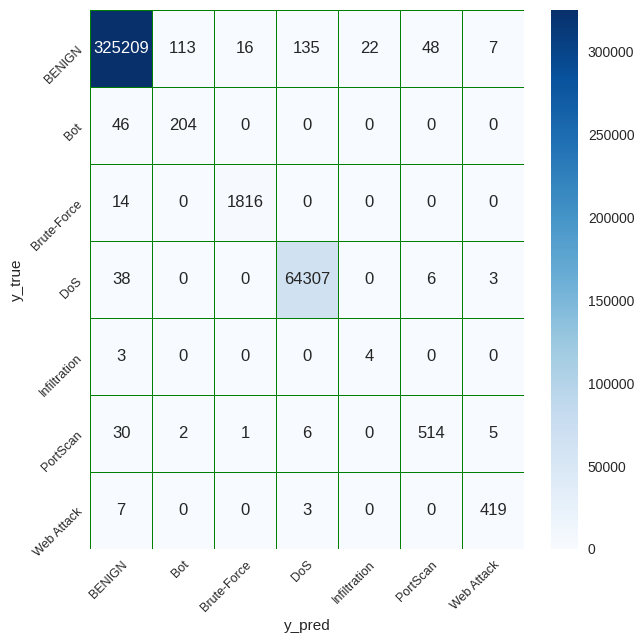

In [70]:
from functools import cmp_to_key
# I corrected the print instractions
print('Accuracy of proposed method: '+ (str(ac)))
print('Precision of proposed method: '+ (str(precision)))
print('Recall of proposed method: '+ (str(recall)))
print('F1-score of proposed method: '+ (str(fscore)))

# Same as before without any modifications
y_dec = label_decoder(y, labelencoder)
cm = confusion_matrix(y_true_dec, y_dec)
f,ax=plt.subplots(figsize=(7,7))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax, cmap='Blues')
plt.xlabel("y_pred")
plt.ylabel("y_true")


ax.tick_params(axis='both', which='major', labelsize=9)
ax.xaxis.set_ticklabels(np.unique(y_true_dec));
ax.yaxis.set_ticklabels(np.unique(y_dec));

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [ ]:
#TYPE OF ATTACK
#BENIGN                        2273097
#DoS Hulk                       231073
#PortScan                       158930
#DDoS                           128027
#DoS GoldenEye                   10293
#FTP-Patator                      7938
#SSH-Patator                      5897
#DoS slowloris                    5796
#DoS Slowhttptest                 5499
#Bot                              1966
#Web Attack � Brute Force         1507
#Web Attack � XSS                  652
#Infiltration                       36
#Web Attack � Sql Injection         21
#Heartbleed                         11